In [1]:
#cell 1
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 

CSV_PATH = "/cluster/home/miolate21/FER_biasmitigation1/results/attributes_jpg.csv" 

print(f"Loading data from: {CSV_PATH}")
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"ERROR: Cannot find CSV file at {CSV_PATH}")
    print("Please ensure the path is correct and the file exists.")
    raise SystemExit("CSV file not found.")

print(f"Rows loaded: {len(df)}")

required_cols_initial = ['image_path', 'status', 'dominant_race', 'emotion']
if not all(col in df.columns for col in required_cols_initial):
    if 'race' in df.columns:
         df.rename(columns={'race': 'dominant_race'}, inplace=True) 
    else:
         raise ValueError(f"CSV missing required columns. Need at least: {required_cols_initial}")

if not all(col in df.columns for col in required_cols_initial):
     raise ValueError(f"CSV missing required columns after potential rename. Need: {required_cols_initial}")


df = df[df['status'] == 'OK'].copy()
df.rename(columns={'dominant_race': 'race'}, inplace=True) # Final rename
df.dropna(subset=['image_path', 'emotion', 'race'], inplace=True)

print(f"Rows after initial filtering (OK status, non-null): {len(df)}")
if df.empty:
    raise ValueError("No valid rows remaining after initial filtering.")

print("Sample image path:", df['image_path'].iloc[0])
if df['image_path'].str.contains(r'\.npy$', regex=True).any():
    print("\nWARNING: Some image paths end with .npy! This cell expects .jpg, .png etc.")
    print("Ensure you loaded the correct CSV from the IMAGE processing script.")
 
df['label'] = df['emotion'].astype('category').cat.codes
df['race_label'] = df['race'].astype('category').cat.codes

emotion_map = dict(enumerate(df['emotion'].astype('category').cat.categories))
race_map = dict(enumerate(df['race'].astype('category').cat.categories))
idx_to_emotion = {v: k for k, v in emotion_map.items()}
idx_to_race = {v: k for k, v in race_map.items()}
num_emotion_classes = len(emotion_map)
num_race_classes = len(race_map)

print(f"Found {num_emotion_classes} emotion classes: {emotion_map}")
print(f"Found {num_race_classes} race classes: {race_map}")
print("DataFrame prepared with labels.")
print(df[['image_path', 'emotion', 'race', 'label', 'race_label']].head())

Loading data from: /cluster/home/miolate21/FER_biasmitigation1/results/attributes_jpg.csv
Rows loaded: 41478
Rows after initial filtering (OK status, non-null): 40649
Sample image path: /cluster/home/miolate21/FER_biasmitigation1/data/fer2013/train/happy/Training_6312930.jpg
Found 7 emotion classes: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
Found 6 race classes: {0: 'asian', 1: 'black', 2: 'indian', 3: 'latino hispanic', 4: 'middle eastern', 5: 'white'}
DataFrame prepared with labels.
                                          image_path emotion   race  label  \
0  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white      3   
1  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white      3   
2  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white      3   
3  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white      3   
4  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white      

In [2]:
#cell 2
import tensorflow as tf
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

@tf.function
def load_and_prep_image_adv(path, label, race):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img, label, race

def build_adv_dataset(df_subset, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((
        df_subset['image_path'].values,
        df_subset['label'].values.astype("int32"),
        df_subset['race_label'].values.astype("int32")
    ))
    if shuffle:
        buffer_size = min(len(df_subset), 10000)
        ds = ds.shuffle(buffer_size=buffer_size, seed=42, reshuffle_each_iteration=True)


    ds = ds.repeat() 


    ds = ds.map(load_and_prep_image_adv, num_parallel_calls=AUTOTUNE)


    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

print("Splitting data...")
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

print("Building train dataset...")
train_ds = build_adv_dataset(train_df, shuffle=True)
print("Building validation dataset...")
val_ds = build_adv_dataset(val_df, shuffle=False)

print("Datasets built.")
print("Train Dataset Spec:", train_ds.element_spec)

Splitting data...
Training samples: 32519, Validation samples: 8130
Building train dataset...
Building validation dataset...
Datasets built.
Train Dataset Spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [3]:
#cell 3
import tensorflow as tf
from tensorflow.keras.layers import Layer

class GradientReversalLayer(Layer):

    def __init__(self, lambda_coeff=1.0, **kwargs):
        super().__init__(**kwargs)

        self.lambda_coeff = tf.Variable(float(lambda_coeff), trainable=False, name="grl_lambda")

    def call(self, x):
        @tf.custom_gradient
        def _flip_grad(x_input):
            def grad(dy):
                return -self.lambda_coeff * dy
            return x_input, grad 
        return _flip_grad(x)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_coeff": self.lambda_coeff.numpy()}) # Save numpy value
        return config

print("GradientReversalLayer defined.")

GradientReversalLayer defined.


In [4]:
#cell 4
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Layer

class GradientReversalLayer(Layer):
    def __init__(self, lambda_coeff=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_coeff = tf.Variable(float(lambda_coeff), trainable=False, name="grl_lambda")

    def call(self, x):
        @tf.custom_gradient
        def _flip_grad(x_input):
            def grad(dy):
                return -self.lambda_coeff * dy
            return x_input, grad
        return _flip_grad(x)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_coeff": self.lambda_coeff.numpy()})
        return config

if 'IMG_SIZE' not in locals(): raise NameError("IMG_SIZE not defined.")
if 'num_emotion_classes' not in locals(): raise NameError("num_emotion_classes not defined.")
if 'num_race_classes' not in locals(): raise NameError("num_race_classes not defined.")

print("Building adversarial model for fine-tuning...")

inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inp,
    pooling='avg'
)

base_model.trainable = True
print(f"Set base_model.trainable = True")

freeze_until_layer = 50
print(f"Freezing base_model layers up to index {freeze_until_layer}...")
if freeze_until_layer > 0:
   for layer in base_model.layers[:freeze_until_layer]:
       layer.trainable = False
for layer in base_model.layers[freeze_until_layer:]:
    layer.trainable = True
print(f"Set layers after index {freeze_until_layer} to trainable.")
print(f"Total layers: {len(base_model.layers)}. Non-trainable base layers: {len(base_model.layers[:freeze_until_layer]) if freeze_until_layer > 0 else 0}")

features = base_model.output

x_emotion = layers.Dropout(0.5, name='dropout_emotion')(features)
emotion_out = layers.Dense(num_emotion_classes, activation='softmax', name="emotion")(x_emotion)

grl_lambda = 1.0
reversed_features = GradientReversalLayer(lambda_coeff=grl_lambda, name='gradient_reversal')(features)
race_out = layers.Dense(num_race_classes, activation='softmax', name="race")(reversed_features)

model = models.Model(inputs=inp, outputs=[emotion_out, race_out], name="adversarial_emotion_model_finetune")

print("Adversarial fine-tuning model built.")
model.summary()

Building adversarial model for fine-tuning...
Set base_model.trainable = True
Freezing base_model layers up to index 50...
Set layers after index 50 to trainable.
Total layers: 176. Non-trainable base layers: 50
Adversarial fine-tuning model built.


Model: "adversarial_emotion_model_finetune"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_image[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,614,349 (90.08 MB)

 Trainable params: 22,953,741 (87.56 MB)

 Non-trainable params: 660,608 (2.52 MB)

In [5]:
#cell 5

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

if 'train_ds' not in locals() or 'val_ds' not in locals():
     raise NameError("Training/Validation datasets (train_ds, val_ds) not defined.")
if 'train_df' not in locals() or 'val_df' not in locals():
     raise NameError("Training/Validation dataframes (train_df, val_df) not defined.")
if 'BATCH_SIZE' not in locals():
     raise NameError("BATCH_SIZE not defined.")

initial_learning_rate = 5e-5
emotion_loss_weight = 1.0
race_loss_weight = 0.5

print(f"Compiling model with Adam (LR={initial_learning_rate})...")
print(f"Loss weights: Emotion={emotion_loss_weight}, Race={race_loss_weight}")

model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss={
        "emotion": "sparse_categorical_crossentropy",
        "race": "sparse_categorical_crossentropy"
    },
    loss_weights={
        "emotion": emotion_loss_weight,
        "race": race_loss_weight
    },
    metrics={
        "emotion": "accuracy",
        "race": "accuracy"
    }
)

def data_generator(dataset):
    for image, label, race_label in dataset:
        yield image, {"emotion": label, "race": race_label}

train_data_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(train_ds),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        {
            "emotion": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            "race": tf.TensorSpec(shape=(None,), dtype=tf.int32),
        }
    )
)
val_data_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(val_ds),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        {
            "emotion": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            "race": tf.TensorSpec(shape=(None,), dtype=tf.int32),
        }
    )
)

print("Data generators ready.")

steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
if len(train_df) % BATCH_SIZE != 0: steps_per_epoch += 1
if len(val_df) % BATCH_SIZE != 0: validation_steps += 1

print(f"Calculated steps_per_epoch: {steps_per_epoch}")
print(f"Calculated validation_steps: {validation_steps}")

callbacks = [
    ModelCheckpoint(
        filepath="models/resnet50_adversarial_finetune50_best.keras",
        save_best_only=True,
        monitor="val_emotion_accuracy",
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_emotion_accuracy',
        factor=0.5,
        patience=4,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_emotion_accuracy',
        patience=8,
        mode='max',
        verbose=1,
        restore_best_weights=True
    )
]

print("Callbacks defined.")

EPOCHS = 30
print(f"Starting adversarial fine-tuning for {EPOCHS} epochs...")

history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_freq=1
)

print("Adversarial fine-tuning finished.")

Compiling model with Adam (LR=5e-05)...
Loss weights: Emotion=1.0, Race=0.5
Data generators ready.
Calculated steps_per_epoch: 1017
Calculated validation_steps: 255
Callbacks defined.
Starting adversarial fine-tuning for 30 epochs...
Epoch 1/30


I0000 00:00:1745813651.685949  700042 service.cc:146] XLA service 0x7f3304001e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745813651.685975  700042 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6


   1/1017 ━━━━━━━━━━━━━━━━━━━━ 8:09:25 29s/step - emotion_accuracy: 0.0625 - emotion_loss: 2.5434 - loss: 3.8468 - race_accuracy: 0.0000e+00 - race_loss: 1.3033

I0000 00:00:1745813667.948659  700042 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1017/1017 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - emotion_accuracy: 0.2520 - emotion_loss: 2.1369 - loss: 11.8636 - race_accuracy: 0.0497 - race_loss: 9.7267  
Epoch 1: val_emotion_accuracy improved from -inf to 0.43468, saving model to models/resnet50_adversarial_finetune50_best.keras
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 99s 69ms/step - emotion_accuracy: 0.2520 - emotion_loss: 2.1367 - loss: 11.8626 - race_accuracy: 0.0498 - race_loss: 9.7259 - val_emotion_accuracy: 0.4347 - val_emotion_loss: 1.4908 - val_loss: 5.0926 - val_race_accuracy: 0.0518 - val_race_loss: 3.6019 - learning_rate: 5.0000e-05
Epoch 2/30
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - emotion_accuracy: 0.3677 - emotion_loss: 2.1656 - loss: 7.1313 - race_accuracy: 0.2159 - race_loss: 4.9657 
Epoch 2: val_emotion_accuracy did not improve from 0.43468
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 63s 62ms/step - emotion_accuracy: 0.3676 - emotion_loss: 2.1658 - loss: 7.1312 - race_accuracy: 0.2159 - race_loss: 4.9654 - val_emotion_accuracy: 0.3

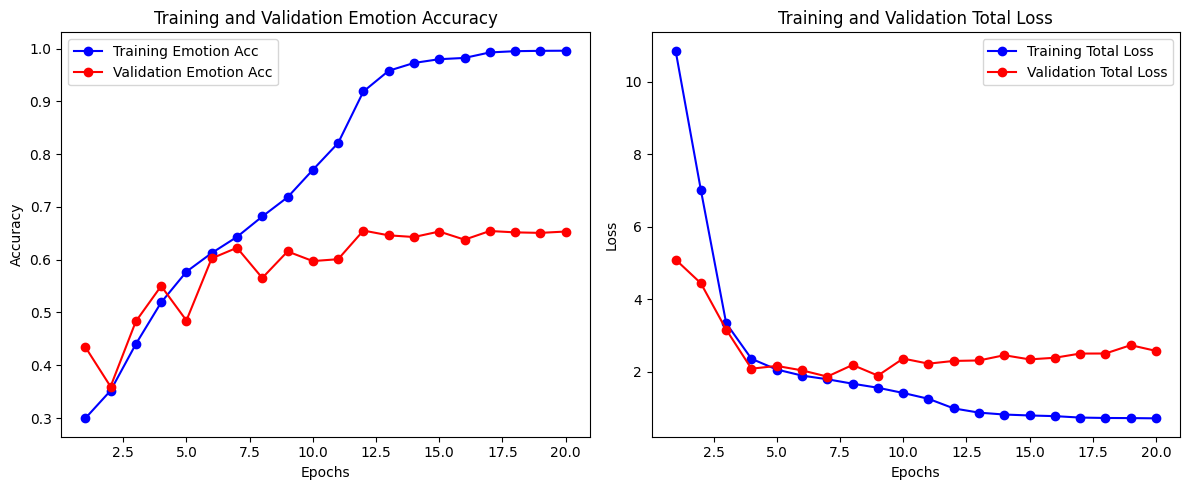

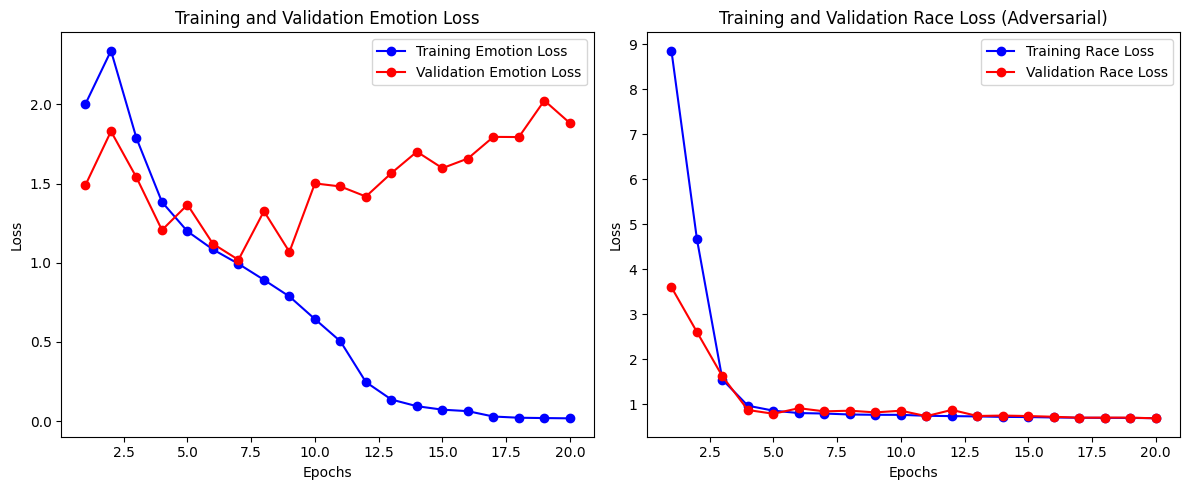

In [6]:
#cell 5a

import matplotlib.pyplot as plt
import math

if 'history' in locals() and hasattr(history, 'history') and history.history:
    history_dict = history.history

    acc_key = 'emotion_accuracy'
    val_acc_key = 'val_emotion_accuracy'
    loss_key = 'loss'
    val_loss_key = 'val_loss'
    emotion_loss_key = 'emotion_loss'
    val_emotion_loss_key = 'val_emotion_loss'
    race_loss_key = 'race_loss'
    val_race_loss_key = 'val_race_loss'

    if loss_key not in history_dict or val_loss_key not in history_dict or \
       acc_key not in history_dict or val_acc_key not in history_dict:
        print("Error: Essential training/validation keys not found in history object.")
        print("Available keys:", history_dict.keys())
    else:
        num_train_epochs = len(history_dict[loss_key])
        num_val_epochs_logged = len(history_dict[val_loss_key])

        epochs = range(1, num_train_epochs + 1)

        validation_log_step = 1
        if num_val_epochs_logged > 0:
            validation_log_step = math.ceil(num_train_epochs / num_val_epochs_logged)

        val_epochs_indices = range(validation_log_step, num_train_epochs + 1, validation_log_step)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history_dict[acc_key], 'bo-', label='Training Emotion Acc')
        plt.plot(val_epochs_indices, history_dict[val_acc_key], 'ro-', label='Validation Emotion Acc')
        plt.title('Training and Validation Emotion Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_dict[loss_key], 'bo-', label='Training Total Loss')
        plt.plot(val_epochs_indices, history_dict[val_loss_key], 'ro-', label='Validation Total Loss')
        plt.title('Training and Validation Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

        if emotion_loss_key in history_dict and val_emotion_loss_key in history_dict:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(epochs, history_dict[emotion_loss_key], 'bo-', label='Training Emotion Loss')
            if len(history_dict[val_emotion_loss_key]) == len(val_epochs_indices):
                plt.plot(val_epochs_indices, history_dict[val_emotion_loss_key], 'ro-', label='Validation Emotion Loss')
            else:
                print(f"Warning: Mismatch in validation emotion loss length ({len(history_dict[val_emotion_loss_key])}) vs expected indices ({len(val_epochs_indices)})")
            plt.title('Training and Validation Emotion Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
        else:
            print(f"Warning: Could not find keys for emotion loss ('{emotion_loss_key}', '{val_emotion_loss_key}')")

        if race_loss_key in history_dict and val_race_loss_key in history_dict:
            plt.subplot(1, 2, 2)
            plt.plot(epochs, history_dict[race_loss_key], 'bo-', label='Training Race Loss')
            if len(history_dict[val_race_loss_key]) == len(val_epochs_indices):
                plt.plot(val_epochs_indices, history_dict[val_race_loss_key], 'ro-', label='Validation Race Loss')
            else:
                print(f"Warning: Mismatch in validation race loss length ({len(history_dict[val_race_loss_key])}) vs expected indices ({len(val_epochs_indices)})")
            plt.title('Training and Validation Race Loss (Adversarial)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Could not find keys for race loss ('{race_loss_key}', '{val_race_loss_key}')")

else:
    print("History object not found or is empty. Cannot plot training curves.")

In [9]:
#cell 6

import numpy as np
import tensorflow as tf
import pandas as pd

model_path = "/cluster/home/miolate21/FER_biasmitigation1/notebooks/models/resnet50_adversarial_finetune50_best.keras"
print(f"Loading saved best model from: {model_path}")
model = tf.keras.models.load_model(
    model_path,
    custom_objects={'GradientReversalLayer': GradientReversalLayer}
)
print("Model loaded successfully.")

if 'val_df' not in locals(): raise NameError("Validation DataFrame 'val_df' not found.")
if 'load_and_prep_image_adv' not in locals(): raise NameError("Image loading function 'load_and_prep_image_adv' not found.")

@tf.function
def load_and_prep_image_eval_adv(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img, label

overall_val_ds_pred = tf.data.Dataset.from_tensor_slices((
    val_df["image_path"].values,
    val_df["label"].values.astype("int32")
))
overall_val_ds_pred = overall_val_ds_pred.map(load_and_prep_image_eval_adv, num_parallel_calls=AUTOTUNE)
overall_val_ds_pred = overall_val_ds_pred.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Generating predictions for the validation set...")
predictions_list = model.predict(overall_val_ds_pred)
y_pred_proba = predictions_list[0]
y_pred = np.argmax(y_pred_proba, axis=1)
print(f"Predictions generated. Shape: {y_pred.shape}")

y_true = val_df['label'].values
print(f"True labels extracted. Shape: {y_true.shape}")

if len(y_true) != len(y_pred):
    raise ValueError("Mismatch between number of true labels and predictions.")

print("Prediction and true label arrays ready.")

Loading saved best model from: /cluster/home/miolate21/FER_biasmitigation1/notebooks/models/resnet50_adversarial_finetune50_best.keras
Model loaded successfully.
Generating predictions for the validation set...
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
Predictions generated. Shape: (8130,)
True labels extracted. Shape: (8130,)
Prediction and true label arrays ready.


In [10]:
#cell 7
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import numpy as np
import pandas as pd

def calculate_per_group_metrics(df, y_true, y_pred, group_col='race', label_col='label'):
    results = {}
    unique_groups = sorted(df[group_col].unique())
    num_classes = max(y_true.max(), y_pred.max()) + 1
    class_labels = list(range(num_classes))

    if len(df) != len(y_true) or len(df) != len(y_pred):
        raise ValueError(f"Length mismatch: df={len(df)}, y_true={len(y_true)}, y_pred={len(y_pred)}")

    df_reset = df.reset_index(drop=True)
    y_true = y_true[:len(df_reset)]
    y_pred = y_pred[:len(df_reset)]

    for group in unique_groups:
        idx = (df_reset[group_col] == group)
        y_true_group = y_true[idx]
        y_pred_group = y_pred[idx]

        if len(y_true_group) == 0:
            continue

        cm = confusion_matrix(y_true_group, y_pred_group, labels=class_labels)
        recall = recall_score(y_true_group, y_pred_group, average=None, labels=class_labels, zero_division=0)
        precision = precision_score(y_true_group, y_pred_group, average=None, labels=class_labels, zero_division=0)
        support = np.bincount(y_true_group, minlength=num_classes)[class_labels]
        accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0

        results[group] = {
            'cm': cm,
            'recall_per_class': recall,
            'precision_per_class': precision,
            'support_per_class': support,
            'accuracy': accuracy
        }

    return results

def calculate_fairness_gaps(group_metrics):
    if not group_metrics:
        return {"max_accuracy_gap": np.nan, "min_recall_gap": np.nan}

    accuracies = [
        m['accuracy']
        for m in group_metrics.values()
        if 'accuracy' in m and len(m['support_per_class']) > 0 and np.sum(m['support_per_class']) > 0
    ]

    min_recalls_per_group = []
    for metrics in group_metrics.values():
        recalls = metrics['recall_per_class']
        support = metrics['support_per_class']
        recalls_present = recalls[support > 0]
        if len(recalls_present) > 0:
            min_recalls_per_group.append(np.min(recalls_present))

    max_acc_gap = np.max(accuracies) - np.min(accuracies) if accuracies else np.nan
    min_recall_gap = np.max(min_recalls_per_group) - np.min(min_recalls_per_group) if min_recalls_per_group else np.nan

    print(f"Calculated Max Accuracy Gap: {max_acc_gap:.4f}")
    print(f"Calculated Min Recall Gap: {min_recall_gap:.4f}")

    return {
        "max_accuracy_gap": max_acc_gap,
        "min_recall_gap": min_recall_gap
    }

print("Metric functions defined.")

Metric functions defined.


Calculating per-group metrics...

Calculating fairness gaps...
Calculated Max Accuracy Gap: 0.1266
Calculated Min Recall Gap: 0.3056

DETAILED FAIRNESS ANALYSIS (Adversarial Model)

Overall Validation Accuracy (Calculated): 0.6556 (65.56%)
Maximum Accuracy Gap Across Races: 0.1266 (12.66%)
Minimum Recall Gap Across Races*: 0.3056 (30.56%)
*Min Recall Gap compares the recall of the most difficult emotion between groups.
------------------------------------------------------------

--- Metrics for Race: asian ---
  Overall Accuracy: 0.6658

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.515      0.526      136
disgust    0.311      0.609       45
fear       0.274      0.312      106
happy      0.824      0.881      442
neutral    0.622      0.649      291
sad        0.710      0.577      317
surprise   0.720      0.688      132


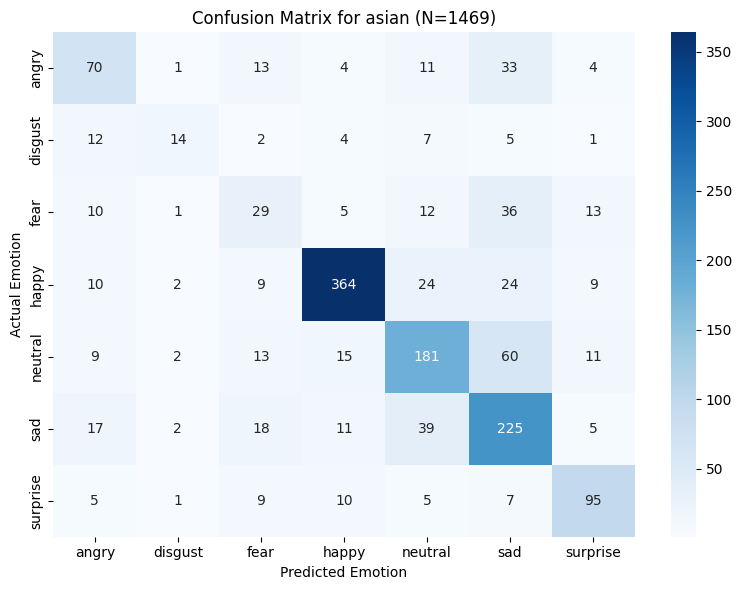


--- Metrics for Race: black ---
  Overall Accuracy: 0.7058

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.648      0.660       54
disgust    0.111      0.200        9
fear       0.179      0.389       39
happy      0.936      0.797      172
neutral    0.699      0.762      183
sad        0.563      0.488       71
surprise   0.721      0.721       43


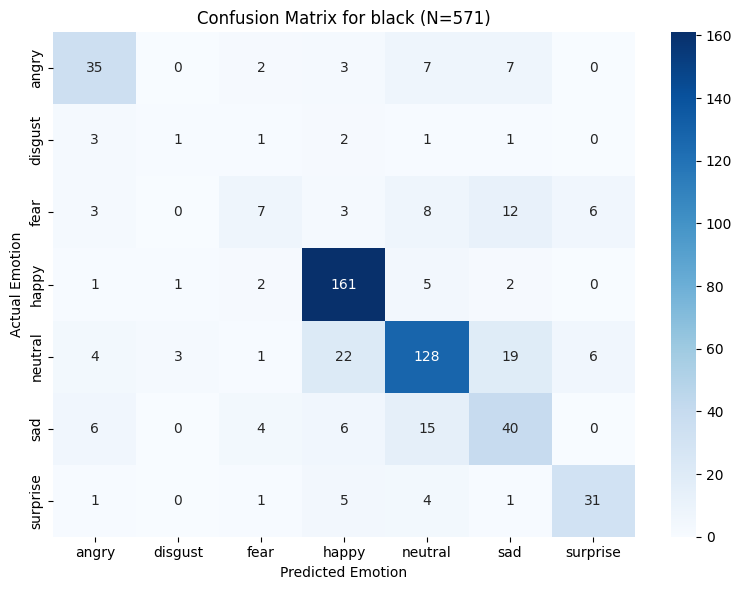


--- Metrics for Race: indian ---
  Overall Accuracy: 0.6603

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.526      0.714       19
disgust    0.500      0.143        2
fear       0.417      0.455       12
happy      0.788      0.820       52
neutral    0.632      0.686       38
sad        0.773      0.531       22
surprise   0.455      0.714       11


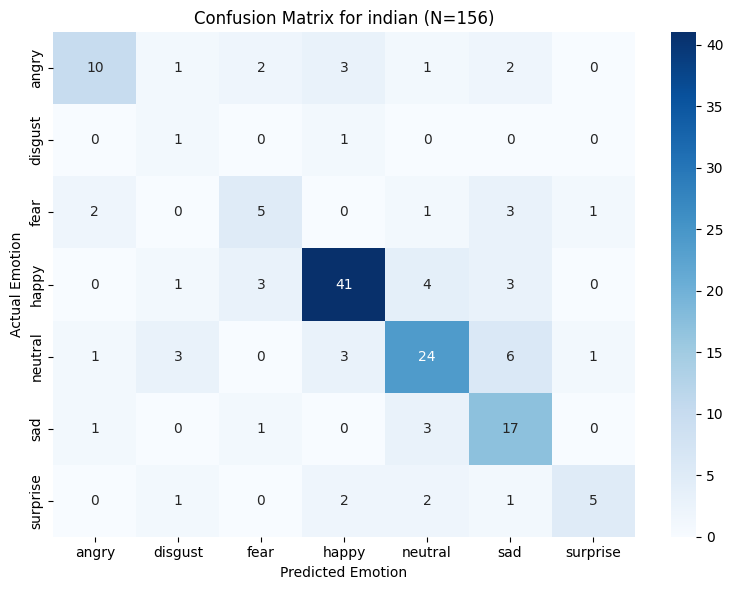


--- Metrics for Race: latino hispanic ---
  Overall Accuracy: 0.6811

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.491      0.475       57
disgust    0.273      0.545       22
fear       0.365      0.500       52
happy      0.909      0.909      186
neutral    0.617      0.556       81
sad        0.651      0.562       83
surprise   0.712      0.698       52


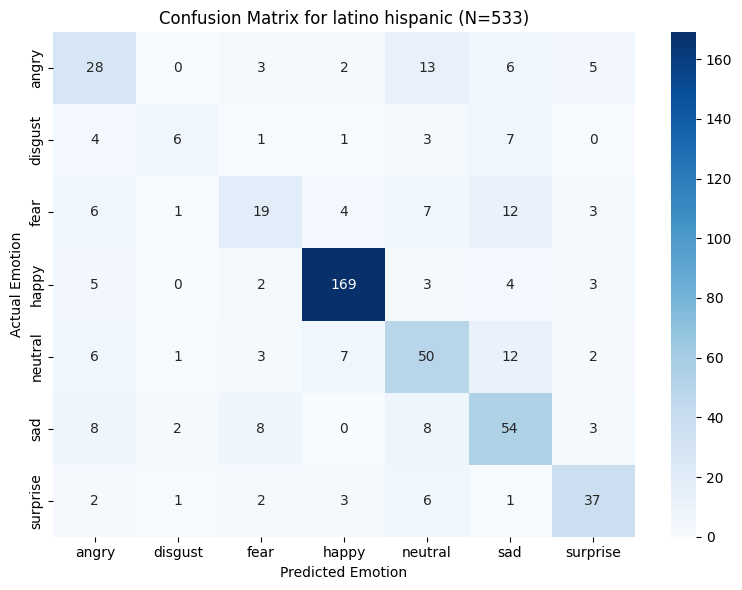


--- Metrics for Race: middle eastern ---
  Overall Accuracy: 0.5792

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.550      0.611       80
disgust    0.381      0.667       21
fear       0.409      0.474       66
happy      0.800      0.782       85
neutral    0.565      0.527       69
sad        0.562      0.414       73
surprise   0.621      0.818       29


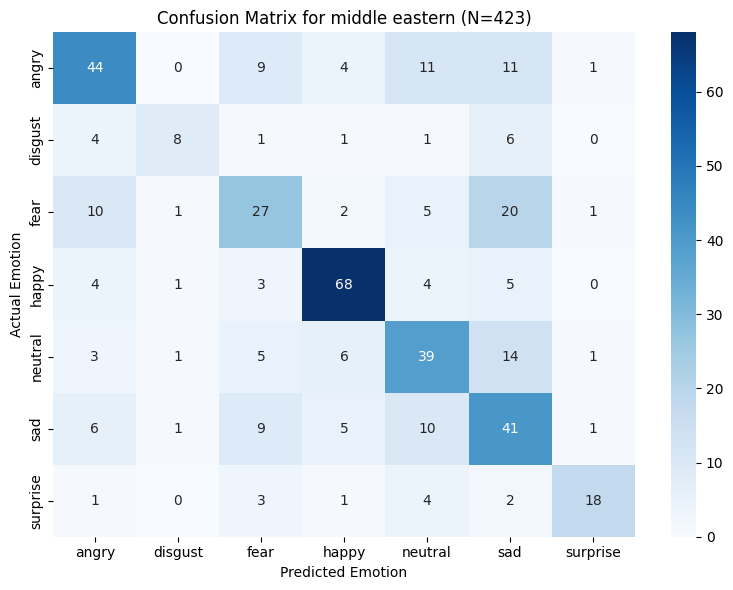


--- Metrics for Race: white ---
  Overall Accuracy: 0.6505

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.483      0.538      584
disgust    0.313      0.538      134
fear       0.443      0.502      594
happy      0.846      0.866     1418
neutral    0.568      0.594      847
sad        0.642      0.471      780
surprise   0.757      0.791      621


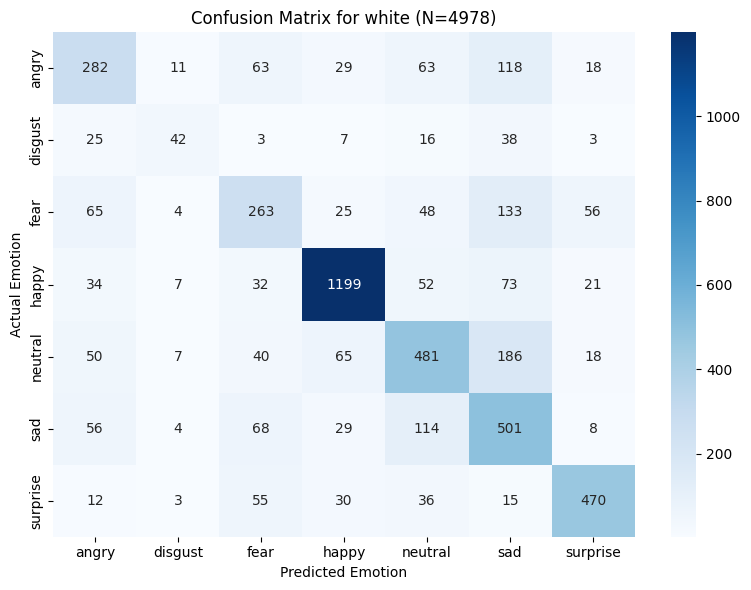


Summary: Per-Emotion Recall Across Races

--- Summary Table with Emotion Names ---
race      asian  black  indian  latino hispanic  middle eastern  white
emotion                                                               
angry     0.515  0.648   0.526            0.491           0.550  0.483
disgust   0.311  0.111   0.500            0.273           0.381  0.313
fear      0.274  0.179   0.417            0.365           0.409  0.443
happy     0.824  0.936   0.788            0.909           0.800  0.846
neutral   0.622  0.699   0.632            0.617           0.565  0.568
sad       0.710  0.563   0.773            0.651           0.562  0.642
surprise  0.720  0.721   0.455            0.712           0.621  0.757

Plotting Overall Validation Accuracy per Race Group...


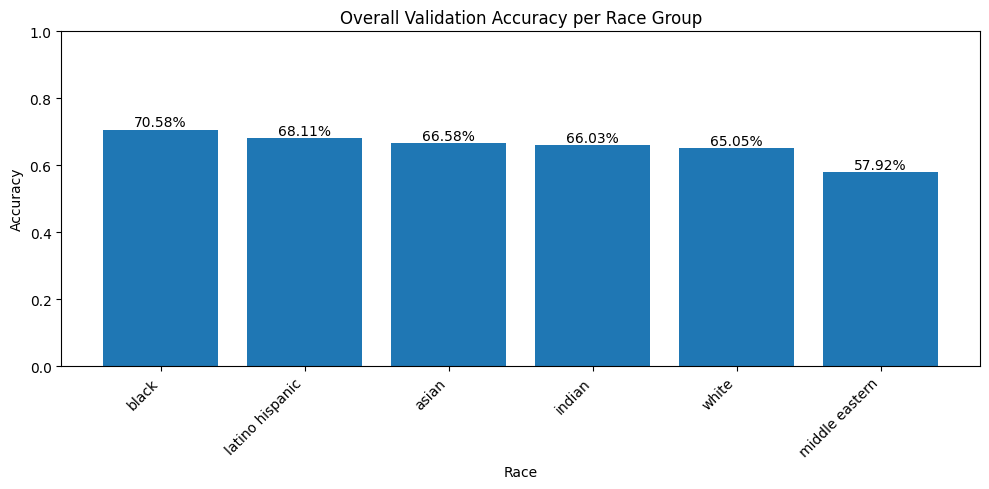


Fairness Analysis Complete


In [16]:

if 'val_df' not in locals() or 'y_true' not in locals() or 'y_pred' not in locals():
    raise NameError("Required variables (val_df, y_true, y_pred) not found.")

idx_to_emotion = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}
emotion_labels = [idx_to_emotion[i] for i in sorted(idx_to_emotion.keys())]

if 'num_emotion_classes' not in locals():
    num_emotion_classes = len(emotion_labels)

print("Calculating per-group metrics...")
per_group_results = calculate_per_group_metrics(val_df, y_true, y_pred, group_col='race')

print("\nCalculating fairness gaps...")
fairness_gaps = calculate_fairness_gaps(per_group_results)

print("\n" + "="*60)
print("DETAILED FAIRNESS ANALYSIS (Adversarial Model)")
print("="*60)

total_samples = len(val_df)
weighted_accuracies = [metrics['accuracy'] * np.sum(metrics['support_per_class'])
                      for metrics in per_group_results.values() if 'accuracy' in metrics and np.sum(metrics['support_per_class']) > 0]
overall_accuracy_eval = np.sum(weighted_accuracies) / total_samples if total_samples > 0 else 0

print(f"\nOverall Validation Accuracy (Calculated): {overall_accuracy_eval:.4f} ({overall_accuracy_eval*100:.2f}%)")
print(f"Maximum Accuracy Gap Across Races: {fairness_gaps['max_accuracy_gap']:.4f} ({fairness_gaps['max_accuracy_gap']*100:.2f}%)")
print(f"Minimum Recall Gap Across Races*: {fairness_gaps['min_recall_gap']:.4f} ({fairness_gaps['min_recall_gap']*100:.2f}%)")
print("*Min Recall Gap compares the recall of the most difficult emotion between groups.")
print("-" * 60)

all_metrics_list = []
for race in sorted(per_group_results.keys()):
    if race not in per_group_results:
        continue
    metrics = per_group_results[race]

    print(f"\n--- Metrics for Race: {race} ---")
    print(f"  Overall Accuracy: {metrics['accuracy']:.4f}")

    print("\n  Per-Emotion Metrics:")
    metrics_df = pd.DataFrame({
        'Recall': metrics['recall_per_class'],
        'Precision': metrics['precision_per_class'],
        'Support': metrics['support_per_class']
    }, index=emotion_labels)

    metrics_df_filtered = metrics_df[metrics_df['Support'] > 0].copy()

    metrics_to_append = metrics_df_filtered.copy()
    metrics_to_append['race'] = race
    metrics_to_append.index.name = 'emotion'
    all_metrics_list.append(metrics_to_append.reset_index())

    print(metrics_df_filtered.round(3))

    cm = metrics['cm']
    present_labels_idx = np.where(metrics['support_per_class'] > 0)[0]
    present_labels_names = [emotion_labels[i] for i in present_labels_idx]

    if len(present_labels_idx) > 0:
        cm_filtered = cm[np.ix_(present_labels_idx, present_labels_idx)]
        cm_df = pd.DataFrame(cm_filtered, index=present_labels_names, columns=present_labels_names)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
                    xticklabels=present_labels_names,
                    yticklabels=present_labels_names)
        plt.title(f'Confusion Matrix for {race} (N={np.sum(cm)})')
        plt.ylabel('Actual Emotion')
        plt.xlabel('Predicted Emotion')
        plt.tight_layout()
        plt.show()
    else:
        print(f"  Skipping confusion matrix for {race} as no samples were present.")

if all_metrics_list:
    print("\n" + "="*60)
    print("Summary: Per-Emotion Recall Across Races")
    print("="*60)
    summary_df_long = pd.concat(all_metrics_list, ignore_index=True)

    try:
        summary_recall_df_numeric = summary_df_long.pivot(index='emotion', columns='race', values='Recall')
        print("\n--- Summary Table with Emotion Names ---")
        print(summary_recall_df_numeric.round(3))
    except KeyError as e:
        print(f"Error creating pivot table: {e}")
        print(summary_df_long.head())
    except Exception as e:
        print(f"Unexpected error during pivot: {e}")
else:
    print("\nNo per-group metrics were calculated to generate a summary table.")

if per_group_results:
    race_overall_accuracies = {race: metrics['accuracy']
                               for race, metrics in per_group_results.items()
                               if 'accuracy' in metrics and np.sum(metrics['support_per_class']) > 0}
    acc_df = pd.DataFrame(race_overall_accuracies.items(), columns=['Race', 'Validation Accuracy']).sort_values(by='Validation Accuracy', ascending=False)
else:
    acc_df = pd.DataFrame()

if not acc_df.empty:
    print("\nPlotting Overall Validation Accuracy per Race Group...")
    plt.figure(figsize=(10, 5))
    plt.bar(acc_df['Race'], acc_df['Validation Accuracy'])
    plt.title('Overall Validation Accuracy per Race Group')
    plt.xlabel('Race')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(acc_df['Validation Accuracy']):
        if not pd.isna(value):
            plt.text(index, value + 0.01, f"{value:.2%}", ha='center')
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping overall accuracy plot as no accuracy data was generated.")

print("\n" + "="*60)
print("Fairness Analysis Complete")
print("="*60)


Overall Emotion Classification Report (Validation Set)
              precision    recall  f1-score   support

       angry       0.55      0.50      0.53       930
     disgust       0.53      0.31      0.39       233
        fear       0.47      0.40      0.43       869
       happy       0.86      0.85      0.86      2355
     neutral       0.62      0.60      0.61      1509
         sad       0.50      0.65      0.56      1346
    surprise       0.77      0.74      0.75       888

    accuracy                           0.66      8130
   macro avg       0.61      0.58      0.59      8130
weighted avg       0.66      0.66      0.65      8130


Overall Emotion Confusion Matrix (Validation Set)


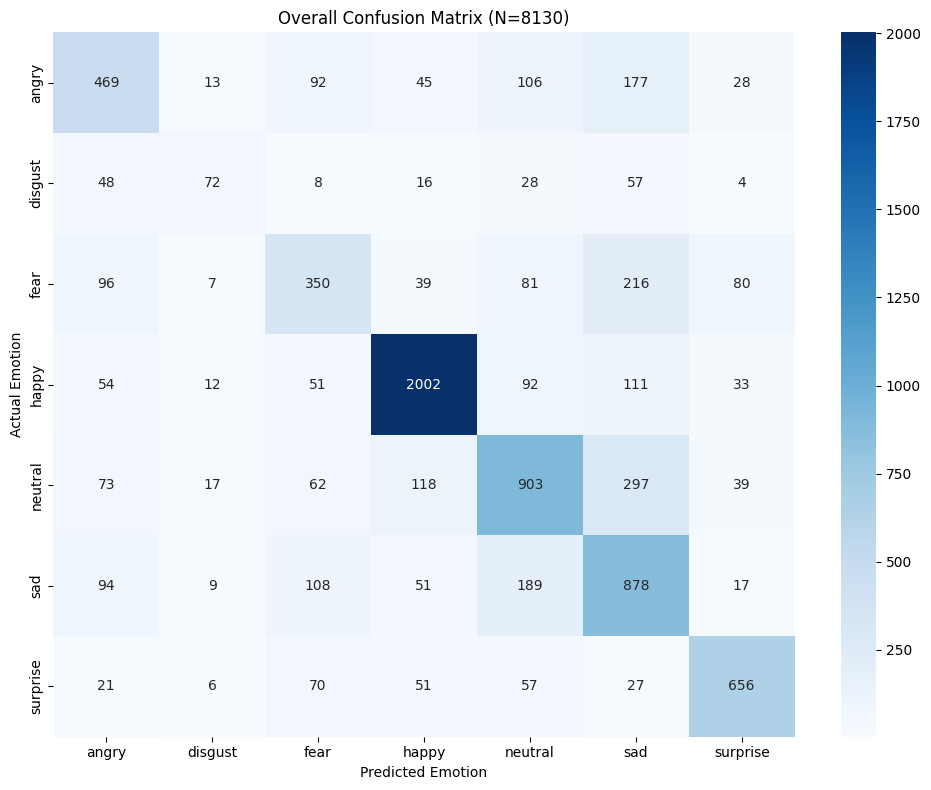

In [17]:
#cell 9

if 'emotion_map' not in locals():
    try:
        _temp_df_for_map = pd.read_csv(CSV_PATH)
        emotion_map = dict(enumerate(_temp_df_for_map['emotion'].astype('category').cat.categories))
    except Exception as e:
        print(f"Could not reconstruct emotion_map: {e}. Proceeding without target names.")
        emotion_map = None

target_names = list(emotion_map.values()) if emotion_map else None
num_classes = len(target_names) if target_names else max(y_true.max(), y_pred.max()) + 1
class_labels = list(range(num_classes))

print("\n" + "="*60)
print("Overall Emotion Classification Report (Validation Set)")
print("="*60)

report = classification_report(y_true, y_pred, labels=class_labels, target_names=target_names, zero_division=0)
print(report)

print("\n" + "="*60)
print("Overall Emotion Confusion Matrix (Validation Set)")
print("="*60)

cm_overall = confusion_matrix(y_true, y_pred, labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names if target_names else class_labels,
            yticklabels=target_names if target_names else class_labels)
plt.title(f'Overall Confusion Matrix (N={len(y_true)})')
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.tight_layout()
plt.show()